In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, UpSampling2D, Concatenate, Input
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from tqdm import tqdm


In [2]:
from google.colab import drive
drive.mount('/content/drive')

DATA_DIR = '/content/drive/MyDrive/dataset/train'  # Yolunu kendi dosyana göre ayarla
IMG_DIR = os.path.join(DATA_DIR, 'k_images')
MSK_DIR = os.path.join(DATA_DIR, 'masks')


Mounted at /content/drive


In [3]:
DATA_DIR = '/content/drive/MyDrive/dataset/train'  # Yolunu kendi dosyana göre ayarla
IMG_DIR = os.path.join(DATA_DIR, 'k_images')
MSK_DIR = os.path.join(DATA_DIR, 'masks')


In [4]:
COLOR_MAP = {
    (0, 255, 0): 0,    # Green = Benign
    (0, 0, 255): 1,    # Blue = Gleason 3
    (255, 255, 0): 2,  # Yellow = Gleason 4
    (255, 0, 0): 3,    # Red = Gleason 5
}
NUM_CLASSES = len(COLOR_MAP)

def rgb_to_class(mask_rgb):
    """RGB mask'i class index'e dönüştür - sadece 4 renk, arka plan yok"""

    # Boş class mask (-1 ile başlat, sonra valid pikselleri işaretle)
    mask_class = np.zeros(mask_rgb.shape[:2], dtype=np.uint8)

    # BGR formatında renk aralıkları
    colors = {
        0: ([0, 200, 200], [50, 255, 255]),   # Sarı = sınıf 0
        1: ([200, 0, 0], [255, 50, 50]),      # Mavi = sınıf 1
        2: ([0, 0, 200], [50, 50, 255]),      # Kırmızı = sınıf 2
        3: ([0, 200, 0], [50, 255, 50])       # Yeşil = sınıf 3
    }

    # Her renk için mask oluştur
    for class_id, (lower, upper) in colors.items():
        lower = np.array(lower)
        upper = np.array(upper)
        color_mask = cv2.inRange(mask_rgb, lower, upper)
        mask_class[color_mask > 0] = class_id

    return mask_class

In [ ]:
IMG_SIZE = 224


def load_data(img_dir, msk_dir):
    images = []
    masks = []
    for file in tqdm(os.listdir(img_dir)):
        if not file.endswith('.png'):
            continue

        img_path = os.path.join(img_dir, file)
        base = os.path.splitext(file)[0]
        mask_name = f"mask_{base}.png"
        msk_path = os.path.join(msk_dir, mask_name)

        if not os.path.exists(msk_path):
            print(f"⚠️ Mask not found for: {file}")
            continue

        img = cv2.imread(img_path)
        if img is None:
            print(f"⚠️ Could not read image: {img_path}")
            continue

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0

        msk = cv2.imread(msk_path)
        if msk is None:
            print(f"⚠️ Could not read mask: {msk_path}")
            continue

        # Mask'i de 112x112 yap (model output ile eşleştirmek için)
        msk = cv2.resize(msk, (112, 112))  # 224 yerine 112
        msk = rgb_to_class(msk)
        msk = to_categorical(msk, num_classes=NUM_CLASSES)

        images.append(img)
        masks.append(msk)

    print(f"✅ Loaded {len(images)} image-mask pairs")
    return np.array(images), np.array(masks)
X, y = load_data(IMG_DIR, MSK_DIR)

100%|██████████| 638/638 [14:52<00:00,  1.40s/it]


✅ Loaded 638 image-mask pairs


In [42]:
def build_model(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=NUM_CLASSES):
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')

    # Öznitelik haritası
    x = base_model.output
    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (3, 3), padding='same', activation='relu')(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(32, (3, 3), padding='same', activation='relu')(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(num_classes, (1, 1), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)
    return model

model = build_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,825,060 (14.59 MB)

 Trainable params: 3,790,948 (14.46 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [49]:
# Train-test split yap
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Şimdi modeli eğit
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=30,
                    batch_size=8)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=30,
                    batch_size=8)


Epoch 1/30


ValueError: Attr 'Toutput_types' of 'OptionalFromValue' Op passed list of length 0 less than minimum 1.

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


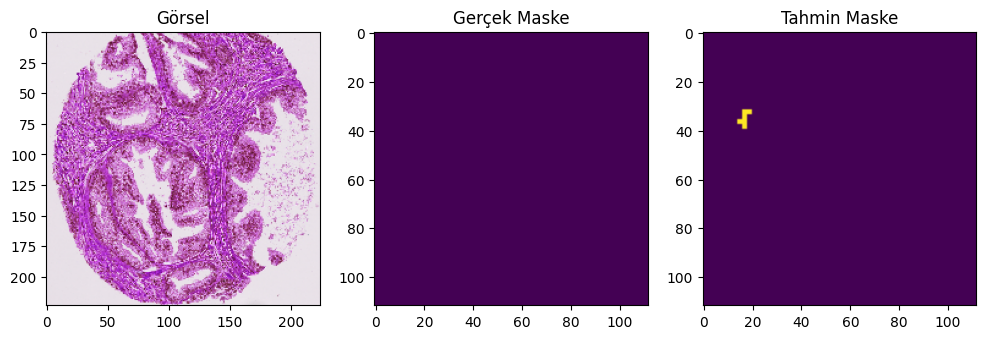

In [33]:
import matplotlib.pyplot as plt

def visualize_prediction(index):
    image = X_val[index]
    true_mask = np.argmax(y_val[index], axis=-1)

    pred = model.predict(np.expand_dims(image, axis=0))[0]
    pred_mask = np.argmax(pred, axis=-1)

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.title('Görsel'); plt.imshow(image)
    plt.subplot(1,3,2); plt.title('Gerçek Maske'); plt.imshow(true_mask)
    plt.subplot(1,3,3); plt.title('Tahmin Maske'); plt.imshow(pred_mask)
    plt.show()

visualize_prediction(0)


Image: ZT204_6_B_7_5.png
Mask: mask_ZT204_6_B_7_5.png
Mask path exists: True
Raw mask shape: (3100, 3100, 3)
Raw mask unique values: [  0 255]
Gray mask unique values: [226 255]
New processed mask unique values: [0]


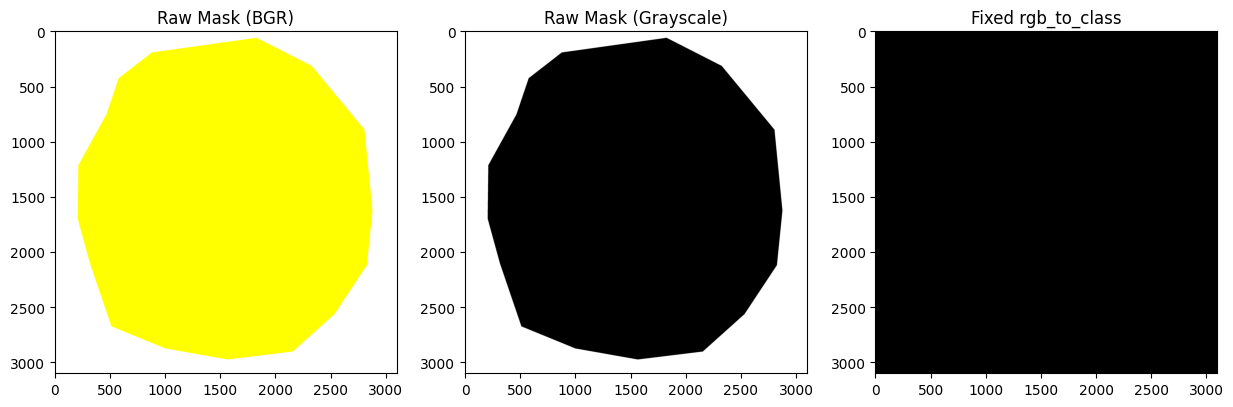

In [37]:
import matplotlib.pyplot as plt

# Bir mask dosyasını debug edelim
sample_img_file = os.listdir(IMG_DIR)[0]  # İlk görüntü dosyası
base = os.path.splitext(sample_img_file)[0]
mask_name = f"mask_{base}.png"
mask_path = os.path.join(MSK_DIR, mask_name)

print(f"Image: {sample_img_file}")
print(f"Mask: {mask_name}")
print(f"Mask path exists: {os.path.exists(mask_path)}")

if os.path.exists(mask_path):
    # Raw mask'i oku
    raw_mask = cv2.imread(mask_path)
    print(f"Raw mask shape: {raw_mask.shape}")
    print(f"Raw mask unique values: {np.unique(raw_mask)}")

    # Mask'i görselleştir
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title("Raw Mask (BGR)")
    plt.imshow(cv2.cvtColor(raw_mask, cv2.COLOR_BGR2RGB))

    plt.subplot(1, 3, 2)
    plt.title("Raw Mask (Grayscale)")
    gray_mask = cv2.cvtColor(raw_mask, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray_mask, cmap='gray')
    print(f"Gray mask unique values: {np.unique(gray_mask)}")

    plt.subplot(1, 3, 3)
    plt.title("After rgb_to_class")

    print(f"New processed mask unique values: {np.unique(processed_mask)}")
    plt.imshow(processed_mask, cmap='gray')
    plt.title("Fixed rgb_to_class")
    plt.show()

    plt.show()